In [ ]:
import requests
import os
import re
import random
import urllib.request

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [ ]:
def parse_reverse_line_w_rhyme(text):
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}
    rhyme_pairs = []

    #99 and 126 do not strictly follow format
    for i in range(154):
        if i+1 == 99 or i+1 == 126: continue
        sonnet_start = i * 15
        if 99 < i+1 < 126: sonnet_start += 1
        elif i+1 > 126: sonnet_start -= 1
        for j in range(3):
            rhyme_pairs.append([lines[sonnet_start+1+j*4][-1], lines[sonnet_start+1+j*4+2][-1]])
            rhyme_pairs.append([lines[sonnet_start+1+j*4+1][-1], lines[sonnet_start+1+j*4+3][-1]])
            for k in range(4):
                obs_elem = []
                line = lines[sonnet_start+1+j*4+k]
                for word in line:
                    word = re.sub(r'[^\w\']', '', word).lower()
                    if word not in obs_map:
                        obs_map[word] = obs_counter
                        obs_counter += 1
                    obs_elem.insert(0, obs_map[word])
                obs.append(obs_elem)
        rhyme_pairs.append([lines[sonnet_start+13][-1], lines[sonnet_start+14][-1]])
        for k in range(2):
            obs_elem = []
            line = lines[sonnet_start+13+k]
            for word in line:
                word = re.sub(r'[^\w\']', '', word).lower()
                if word not in obs_map:
                    obs_map[word] = obs_counter
                    obs_counter += 1
                obs_elem.insert(0, obs_map[word])
            obs.append(obs_elem)
    rhyme_pairs = [[re.sub(r'[^\w\']', '', w).lower() for w in p] for p in rhyme_pairs]
    
    return obs, obs_map, rhyme_pairs

In [ ]:
from Emily_project3_helper import *
shakespeare = open("shakespeare.txt", "r").read()

In [ ]:
reversed_lines, word_map, rhymes = parse_reverse_line_w_rhyme(shakespeare)

In [ ]:
hmm_rhyme_15_hidden = unsupervised_HMM(reversed_lines, 15, 100)

Epoch: 0
Epoch: 10
Epoch: 20
Epoch: 30
Epoch: 40
Epoch: 50
Epoch: 60
Epoch: 70
Epoch: 80
Epoch: 90


In [ ]:
def get_state(O, obs, L):
    prob = [O[i][obs] for i in range(len(O))]
    prob = [p/sum(prob) for p in prob]
    return np.random.choice(L, p=prob)

def get_line_w_ending(hmm, obs_map, end):
    obs = obs_map[end]
    obs_map_r = obs_map_reverser(obs_map)
    s = get_state(hmm.O, obs, hmm.L)
    states = [s]
    sentence = [end]
    for i in range(7):
        s = np.random.choice(range(hmm.L), p=hmm.A[states[-1]])
        states.append(s)
        e = np.random.choice(range(hmm.D), p=hmm.O[s])
        sentence.insert(0, obs_map_r[e])
    return ' '.join(sentence).capitalize()

def rhyme_sample_sonnet(hmm, obs_map, rhymes, seed=None):
    rng = np.random.default_rng(seed=seed)
    sonnet = []
    
    for i in range(3):
        r = rng.choice(len(rhymes), 2)
        end_words = [rhymes[r[0]][0], rhymes[r[1]][0], rhymes[r[0]][1], rhymes[r[1]][1]]
        stanza = [get_line_w_ending(hmm, obs_map, end) for end in end_words]
        stanza.append('\n')
        sonnet.append('\n'.join(stanza))
    rhyme_choice = rng.choice(len(rhymes))
    stanza = [get_line_w_ending(hmm, obs_map, rhymes[rhyme_choice][0]), 
              get_line_w_ending(hmm, obs_map, rhymes[rhyme_choice][1])]
    sonnet.append('\n'.join(stanza))
    
    return '\n'.join(sonnet)

In [ ]:
print(rhyme_sample_sonnet(hmm_rhyme_15_hidden, word_map, rhymes))

Verse fool ears seen from my self o'erworn
The disgrace no that mine woman and heart
Therefore so and thou art remembrance out morn
Thou thou my from for thither have art


Thou and pen they and would the east
December's and with me restored foe o'er shine
The blood private with doth chose thou west
Being thou o'er hush hath wherein so mine


Be means to thee thus must heaven's sight
When as and of then am his wantonness
But and that but they again i night
The witness lease out should know roses less


Swears thy kept mark but then death's bright
My ay love taught in not to night


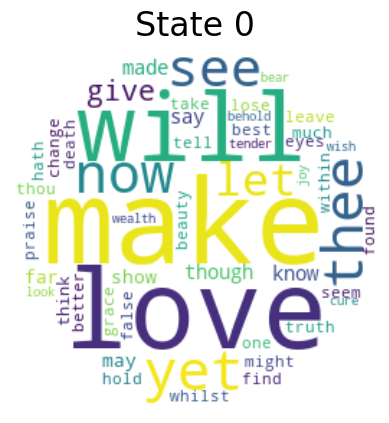

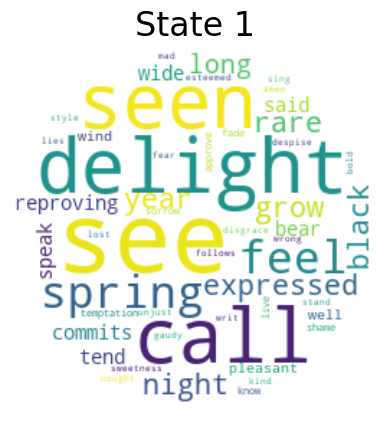

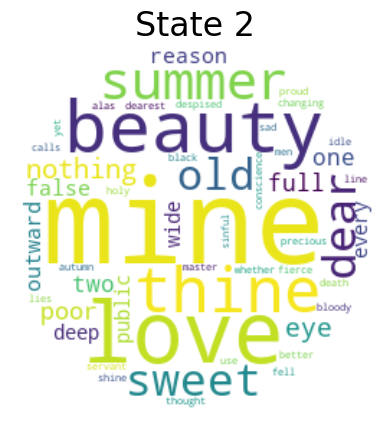

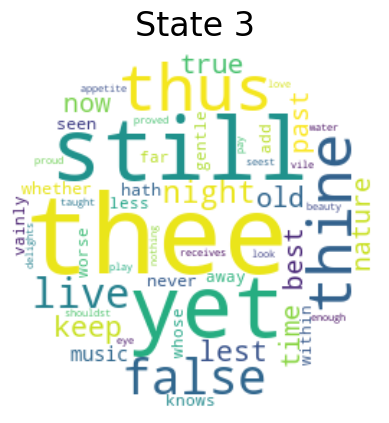

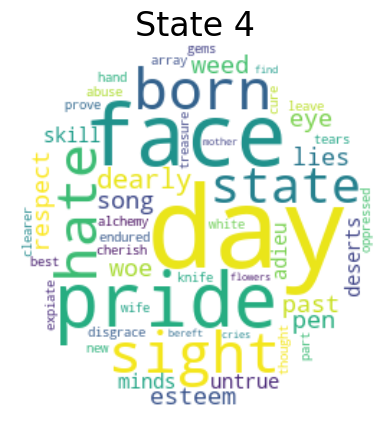

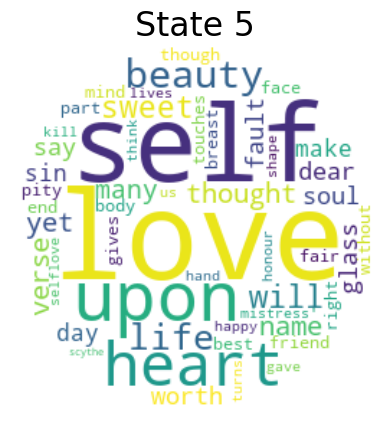

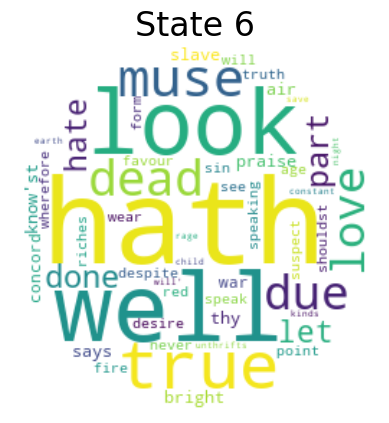

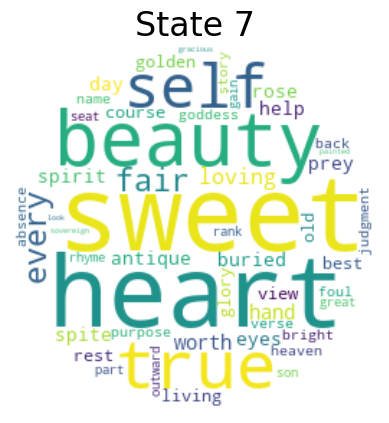

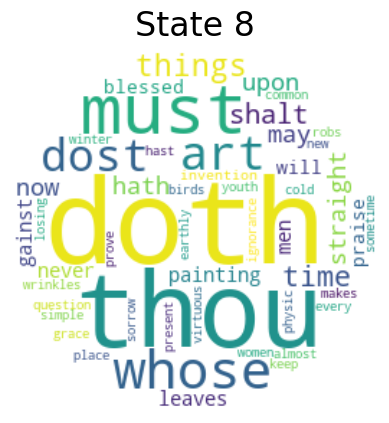

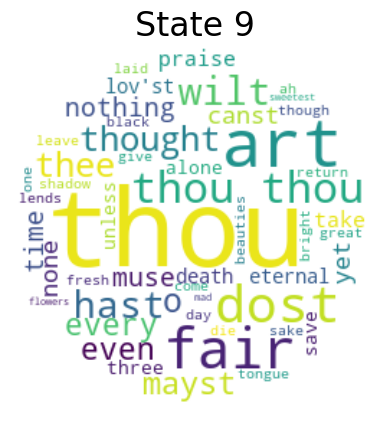

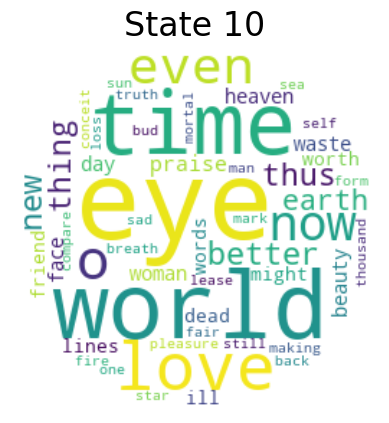

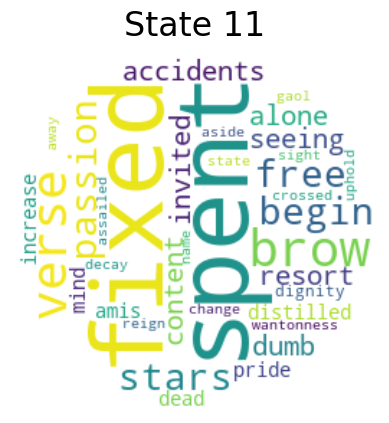

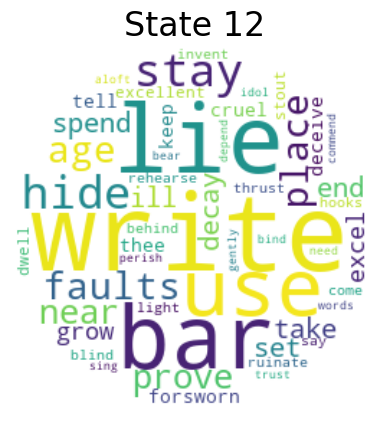

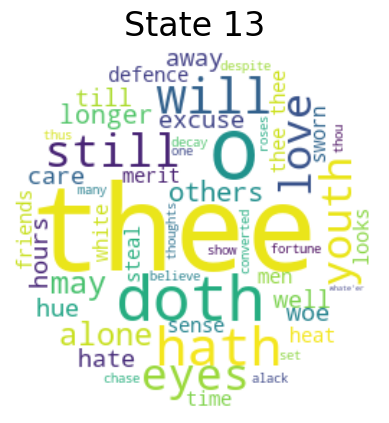

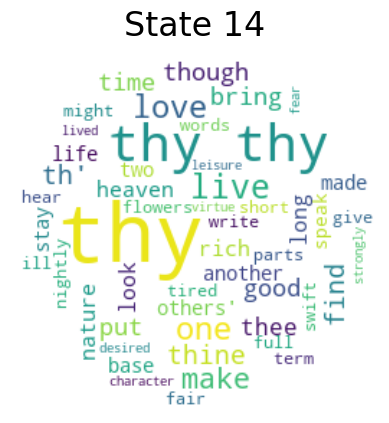

In [ ]:
wordclouds = states_to_wordclouds(hmm_rhyme_15_hidden, word_map)